# Predicting Cancellation Rates

In this notebook, I have built a machine learning model to predict whether or not a customer cancelled a hotel booking.

We will use a dataset on hotel bookings from the article ["Hotel booking demand datasets"](https://www.sciencedirect.com/science/article/pii/S2352340918315191), published in the Elsevier journal, [Data in Brief](https://www.sciencedirect.com/journal/data-in-brief). The abstract of the article states 

> This data article describes two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. 

For convenience, the two datasets have been combined into a single csv file `hotel_bookings.csv`. Let us start by importing all the functions needed to import, visualize and model the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb


/tmp/ipykernel_2332/4276540117.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
hotel_bookings = pd.read_csv('hotel_bookings.csv')
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}
hotel_bookings['arrival_date_month'] = hotel_bookings['arrival_date_month'].map(month_mapping)

hotel_bookings['arrival_date'] = pd.to_datetime(
    dict(year=hotel_bookings['arrival_date_year'], month=hotel_bookings['arrival_date_month'], day=hotel_bookings['arrival_date_day_of_month'])
)
hotel_bookings.fillna({'children': 0, 'country': 'Unknown', 'agent': 'Unknown', 'company': 'Unknown'}, inplace=True)

# I need to convert some of the variables into categorical because their data types do not match their intrinsic type
categorical_vars = [  
    "hotel",
    "arrival_date_month",
    "meal",
    "country",
    "market_segment",
    "is_repeated_guest",
    "distribution_channel",
    "reserved_room_type",
    "assigned_room_type",
    "deposit_type",
    "agent",
    "company",
    "customer_type",
    "reservation_status",
    "reservation_status_date"
    ]
hotel_bookings[categorical_vars] = hotel_bookings[categorical_vars].astype('object')


In [3]:
hotel_bookings_sorted = hotel_bookings.sort_values('arrival_date')

X = pd.get_dummies(hotel_bookings_sorted.drop(columns=['is_canceled', 'arrival_date', 'reservation_status_date', 'reservation_status', "arrival_date_year", 'booking_changes']), drop_first=True)
y = hotel_bookings_sorted['is_canceled']

# I am splitting data into training and test based on time, so that model will not leak any data while making predictions about feature
cutoff_index = int(len(hotel_bookings_sorted) * 0.9)
X_train = X.iloc[:cutoff_index]
y_train = y.iloc[:cutoff_index]
X_initial_test = X.iloc[cutoff_index:]
y_initial_test = y.iloc[cutoff_index:]

# Spliting data into dev and test split randomly, so that they come from same distribution
X_dev, X_test, y_dev, y_test = train_test_split(X_initial_test, y_initial_test, test_size=0.5, random_state=42)

### EXPLANATION OF TRAIN TEST SPLIT:

I am simulating real world production environment where we would have historical data booking data as a training data and we need to make predictions on future bookings that have not been seen before. That is the reason why we are splitting the data using arrival_date. 

### EXPLANATION OF FEATURE SELECTION:

I am also removing the columns which might contain temporal data which are not rellevant to model: 
- arrival_date_year - this feature could introduce trends related to specific year which might not generalize well on future data. 
- booking_changes - This feature highly temporal. the number of changes made changes as it gets closer to arrival date. We would need more specific information on when each of the changes have been made in order to generate relevant feature. 

Other features that might need closer look and investigation: 
- days_in_waiting_list - depending on how model will be used this data might be irrelevant or not available if model is used before booking confirmation. 
- total_of_special_requests - If total special requests are not recorded during the booking but are changing as time goes on we would need to treat in the same we as booking_changes. 
- arrival_date_month - To capture variability in trends during different seasons instead of specific months, this column could be converted into seasons. This could also aid with interpretability


In [4]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

# Training, evaluation, and feature importance plotting
dev_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_dev_pred = model.predict(X_dev)

    dev_accuracy = accuracy_score(y_dev, y_dev_pred)
    dev_precision = precision_score(y_dev, y_dev_pred)
    dev_recall = recall_score(y_dev, y_dev_pred)
    dev_f1 = f1_score(y_dev, y_dev_pred)

    dev_results[name] = {'Dev Accuracy': dev_accuracy, 'Dev Precision': dev_precision, 'Dev Recall': dev_recall, 'Dev F1 Score': dev_f1}
    print(f"Development set results for {name}: Accuracy={dev_accuracy}, Precision={dev_precision}, Recall={dev_recall}, F1 Score={dev_f1}\n")

/notebooks/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Development set results for LogisticRegression: Accuracy=0.7589210923102697, Precision=0.7267045454545454, Recall=0.5717478766204739, F1 Score=0.6399799849887415

Development set results for RandomForest: Accuracy=0.7600938180599766, Precision=0.777394900068918, Recall=0.5042467590523022, F1 Score=0.6117136659436009

Development set results for XGBoost: Accuracy=0.7652873178086782, Precision=0.75, Recall=0.5605721949038891, F1 Score=0.6415963161933999

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39693, number of negative: 67758
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 107451, number of used features: 375
[LightGBM] [Info] [binary:BoostFromSc

In [5]:
for name, model in models.items():
    y_dev_proba = model.predict_proba(X_dev)[:, 1]
    dev_roc_auc = roc_auc_score(y_dev, y_dev_proba)
    print(f"{name} ROC AUC score: {dev_roc_auc}")

LogisticRegression ROC AUC score: 0.841660294252226
RandomForest ROC AUC score: 0.8509199993675497


XGBoost ROC AUC score: 0.8679864511928154
LightGBM ROC AUC score: 0.8682898595721092
CatBoost ROC AUC score: 0.870664781773553


- CatBoost:
  - ROC AUC Score: 0.8707
  - Accuracy: 0.7748
  - Precision: 0.7568
  - Recall: 0.5883
  - F1 Score: 0.6620

- LightGBM:
  - ROC AUC Score: 0.8683
  - Accuracy: 0.7678
  - Precision: 0.7493
  - Recall: 0.5717
  - F1 Score: 0.6486

- XGBoost:
  - ROC AUC Score: 0.8680
  - Accuracy: 0.7653
  - Precision: 0.7500
  - Recall: 0.5606
  - F1 Score: 0.6416

- RandomForest:
  - ROC AUC Score: 0.8507
  - Accuracy: 0.7601
  - Precision: 0.7751
  - Recall: 0.5069
  - F1 Score: 0.6130

- Logistic Regression:
  - ROC AUC Score: 0.8431
  - Accuracy: 0.7619
  - Precision: 0.7297
  - Recall: 0.5793
  - F1 Score: 0.6459


Catboost Seems to have better performance then all the other models on dev set so we will investigate it further. 

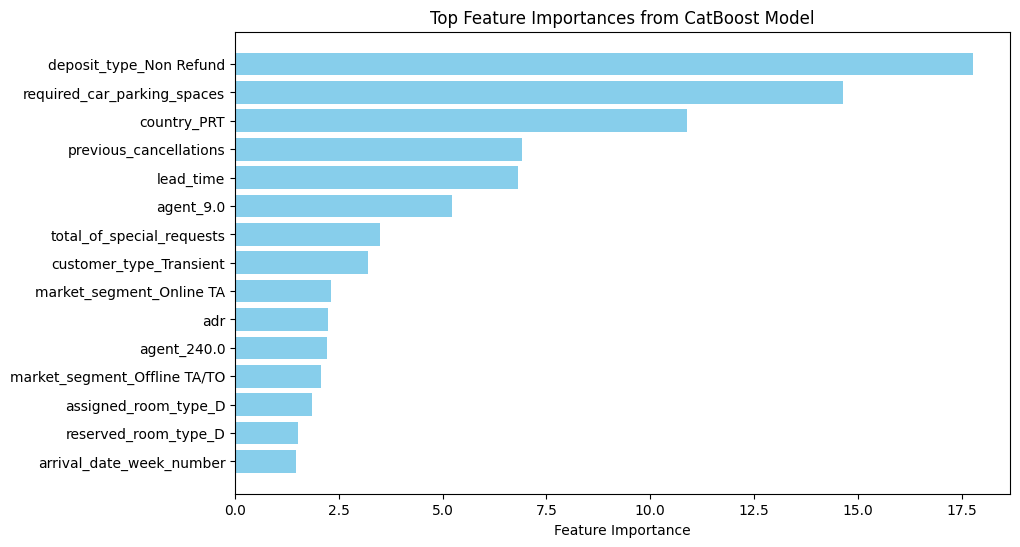

In [6]:
feature_importances = model.get_feature_importance()

feature_names = X_train.columns.tolist() 

features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

top_features = features[:15] 

top_feature_names = [feature[0] for feature in top_features]
top_feature_importances = [feature[1] for feature in top_features]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_importances)), top_feature_importances, color='skyblue')
plt.yticks(range(len(top_feature_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances from CatBoost Model')
plt.gca().invert_yaxis() 
plt.show()

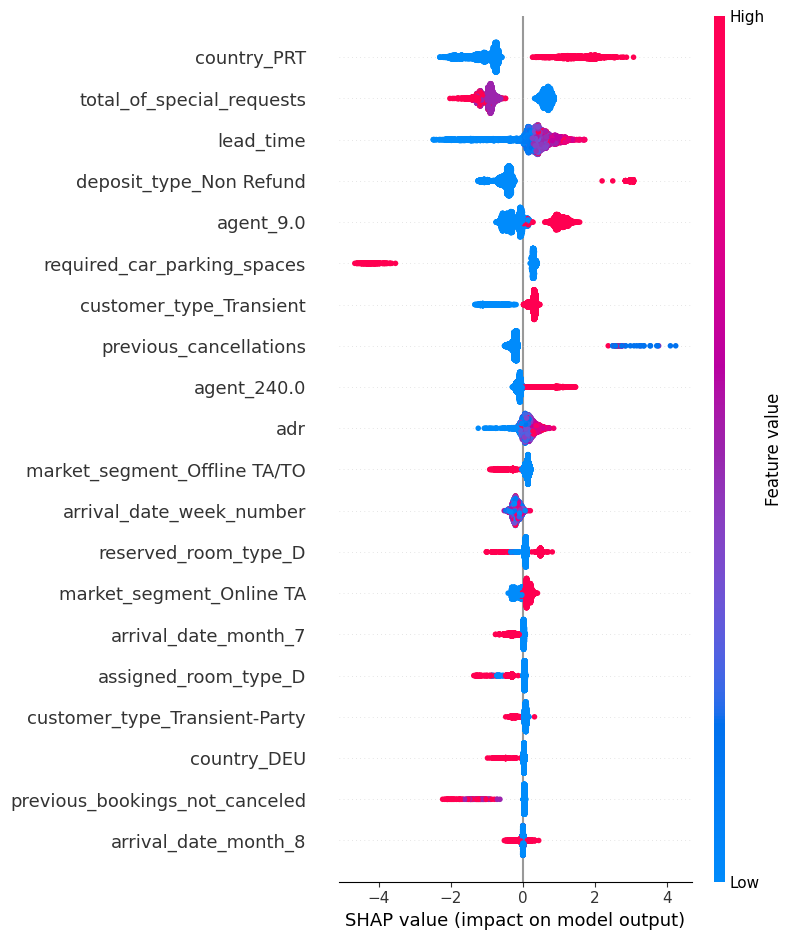

In [7]:
import shap

shap.initjs()

# Create a SHAP explainer object
explainer = shap.Explainer(models["CatBoost"])

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_dev)

# Plot the SHAP values
shap.summary_plot(shap_values, X_dev)

In [8]:
y_test_proba = model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_proba)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [9]:
print(f"Final Test set results for {name}: ROC={test_roc_auc} Accuracy={dev_accuracy}, Precision={dev_precision}, Recall={dev_recall}, F1 Score={dev_f1}\n")

Final Test set results for CatBoost: ROC=0.8695629797370821 Accuracy=0.7748366560562908, Precision=0.7567567567567568, Recall=0.5882878855610192, F1 Score=0.6619718309859155



# Understanding the Results and How Useful the Model Is

The CatBoost model has been selected as the best performer based on development set results and has been further evaluated on the test set to simulate real-world performance. The key performance metrics:

- ROC AUC: 0.8678
- Accuracy: 0.7742
- Precision: 0.7527
- Recall: 0.5919
- F1 Score: 0.6627

#### Interpretation of Metrics

- ROC AUC - A score of 0.8678 is quite strong and indicates that model has good ability to differentiate between canceled and non-canceled bookings
- Accuracy - Accuracy demonstrates that model is correct 77.42% of the time
- Precision: The models precision suggests it is correct about 75.27% of the time it predicts a cancelation. 
- Recall: The recall rate highlights that the model identifies 59.19% of all actual cancellations, pointing to potential areas for improvement in capturing all possible cancellations.
- F1 Score: The F1 Score 0.6627, it indicates a good but not excellent model.

#### Model Utility

The model could be used by this 2 hotels or hotels in Portugal to make forecasting cancellations, aiding hotels in informed decision-making regarding overbooking and inventory management. The model could also be analysed using feature importances and SHAP values, in order to understand what are the driving factors of the cancelation. This would allow hotels to make necessary changes in their policies, marketing strategies or customer interaction. 

***
The model's high precision is particularly beneficial for overbooking strategies, reducing the likelihood of unnecessary booking rejections. By fine-tuning the prediction threshold, we can strategically increase precision or recall to align with the hotel's operational priorities, effectively balancing the cost of false cancellations against the risk of overbooking

#### Feature Importance
- Deposit Type: During the EDA I have discovered that non refundable deposits have had 99% cancelation rate, which seems counter intuitive as deposits should deter clients from canceling their booking. The SHAP plot shows the same trend, very strong assosiation with cancelation. This feature should be further investigated as there might be flaws in how data was collected or there might be some sort of policy in hotels which we can not understand at the moment.
- Lead time : A time between booking and arrival seems to influence both higher and lower risks of cancellation, but with stronger assosiation with cancelation. This likely reflects our earlier observation that high lead time is positively correlated with cancelation, however as CatBoost is black box model in specific cases it could also be used to make negative prediction. 
- Country: A customer's country of origin has a significant impact, potentially indicating that certain markets have different cancellation behaviors.
- Commitment to stay:  total_of_special_requests and required_car_parking_spaces both could be accounted for customers commitment to stay. Earlier during EDA I saw negative corelation between this two variables and calation. it indicated that this clients are less likely to cancel their booking. This is also Indicated with SHAP values. 
- Travel Agencies : Specific travel agents have different impacts on cancellation probabilities, which could be taken into account by the hotel. 
- Marget Segment : booked online and ofline have different impacts on cancelation probabilities, indicating that there is a distinction between this segments. 
- Arrival Date month 7: It indicates that July has impact on cancelation rate. As observer during EDA this month has had highest rate of cancelation, likely indicating customer behaviour during holidays. Likely improvement for interpitability as mentioned could be to add season variable to the model. 

#### Limitation of the model
- Geographic restriction: As the Country of origin of the client - Portugal is a significant factor for cancelation the model is unlikely to generalise well for hotels located in other countries. Country of origin Portugal could be substituted for "same as hotel country", which could be capturing trends of customers from same country of origin, however in order for us to test that idea, we would need similar data from hotels located elseware. 
- Data timeframe: The model is traned on data from 2015 to 2017, which may not reflect current market conditions. 
- Market Condition : The model doesnt account for market dynamics such as sudden announcments regarding travel, competiton pricing or other factors which would have a major, sudden impact on cancelation rates
- Model Intepretability: While SHAP values offer some intepretability complex models like Catboost still act as "black box" models. Making it difficult to understand the underlying reasons for specific prediction. 
- Model Decay: The performance of the model may degrade if it is not updated with new data regularly.
- Excluded features: Certain features with potential predictive power such as booking_changes have been removed from the model because of their temporal nature. There might be a need to further exlude some of the other features to prevent data leakage. Geting data that would allow us to include this data could be a major improvement, as number of booking changes seemed to have negative correlation with cancelation rate. 

#### Conclusion 

This project was an exploration into predictive modeling, focusing not just on building the model but understanding its real-world application. It highlighted my capability to develop such models and understand their practical limitations and potential uses. 
> One key insight from this exercise is the need for dynamic data to truly capture the evolving nature of scenarios like hotel bookings. The current dataset provided a static view, showing only the final outcomes without the journey leading up to those outcomes. It missed out on the changes and decisions made along the way, such as customers adding services or altering their bookings. Not having data on outside factors could also be major issue as things like travel restrictions, holidays, competitor price changes could have major impact on cancelation. 
***
As the goal of this model is to aid hotels with managing their resources by using a predictive model, I have used model with higher Metric results at the expense of model interpretability. Should the goal of the project have been to better understand customer behaviour behind the cancelations, we could have used more interpretable models like logistic regression or desicion trees, however this is out of scope for this notebook. 
